# Overview
The project involves contributors evaluating tweets related to various brands and products. The crowd is tasked with determining whether each tweet expresses positive, negative, or neutral emotions towards a brand and/or product mentioned. Additionally, if there is emotional content, contributors are asked to identify which specific brand or product is being targeted.

# Business Understanding
Understanding public sentiment towards brands and products is crucial for businesses to gauge their reputation, assess customer satisfaction, and identify areas for improvement. Analyzing social media data like tweets provides valuable insights into consumer opinions and preferences.

# Data Understanding
The dataset contains 9093 rows of tweets related to multiple brands and products. Each tweet is annotated by contributors to indicate the sentiment expressed (positive, negative, or neutral) and specify the brand or product targeted by the emotion.

# Main Objective
The main objective of the project is to analyze the sentiment of tweets towards various brands and products. By categorizing the sentiment as positive, negative, or neutral and identifying the specific targets of emotions, the aim is to gain insights into consumer perceptions and attitudes.

## Specific Objectives:

1.Classify each tweet as expressing positive, negative, or neutral sentiment towards brands and products.

2.Identify the specific brands or products targeted by the emotional content in each tweet.

3.Analyze the overall sentiment distribution across brands and products.

4.Explore patterns and trends in consumer sentiment over time or in response to specific events or marketing campaigns.


## Import Relevant Libraries

In [79]:
# import relavant libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import warnings
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelBinarizer



## Load Dataset

In [80]:
# load the dataset
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

data.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Rename the Columns

In [81]:
# Rename the columns
data.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
}, inplace=True)

# Check the updated df
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## EXPLORE THE DATASET

In [82]:
# explore the data
print('The dataset has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
print('\nFeatures:')
print(data.columns.values)
print('\nFirst 5 rows:')
print(data.head())
print('\nInfo:')
print(data.info())


The dataset has 9093 rows and 3 columns

Features:
['tweet' 'product' 'sentiment']

First 5 rows:
                                               tweet             product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

          sentiment  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtype

## Distribution of the Sentiments


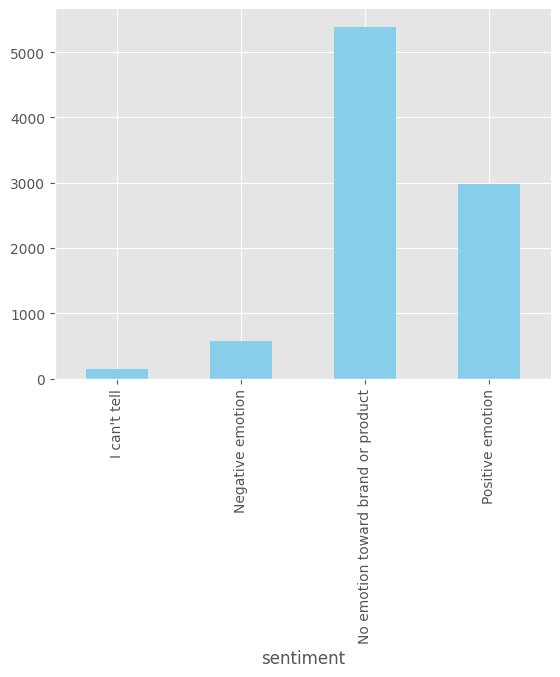

In [83]:
# distribution of the sentiment libraries
data.groupby('sentiment').size().plot(kind='bar', color='skyblue')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Data Visualization of Product

In [84]:
data['product'].value_counts()

product
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

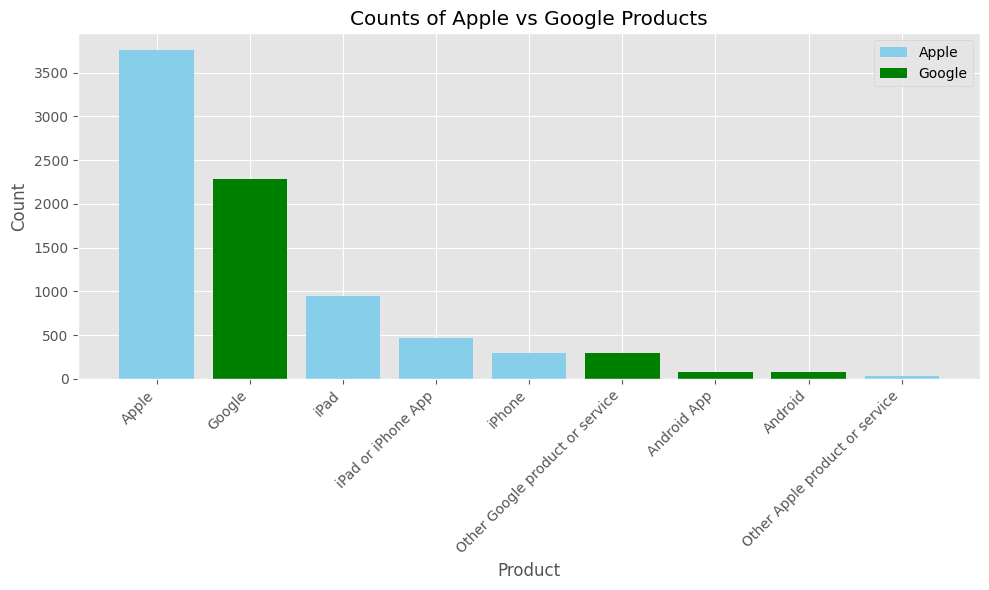

In [85]:
# Data
products = ['Apple', 'Google', 'iPad', 'iPad or iPhone App', 'iPhone',
            'Other Google product or service', 'Android App', 'Android', 'Other Apple product or service']
counts = [3762, 2284, 942, 470, 296, 292, 81, 78, 35]
apple_prod = ['Apple', 'iPad', 'iPad or iPhone App', 'iPhone','Other Apple product or service']

# Colors
colors = ['skyblue' if product in apple_prod else 'green' for product in products]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(products, counts, color=colors)
plt.title('Counts of Apple vs Google Products')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Legend
apple_patch = plt.Rectangle((0,0),1,1,fc="skyblue", edgecolor = 'none')
google_patch = plt.Rectangle((0,0),1,1,fc="green", edgecolor = 'none')
plt.legend([apple_patch, google_patch], ['Apple', 'Google'], loc='upper right')

plt.tight_layout()
plt.show()


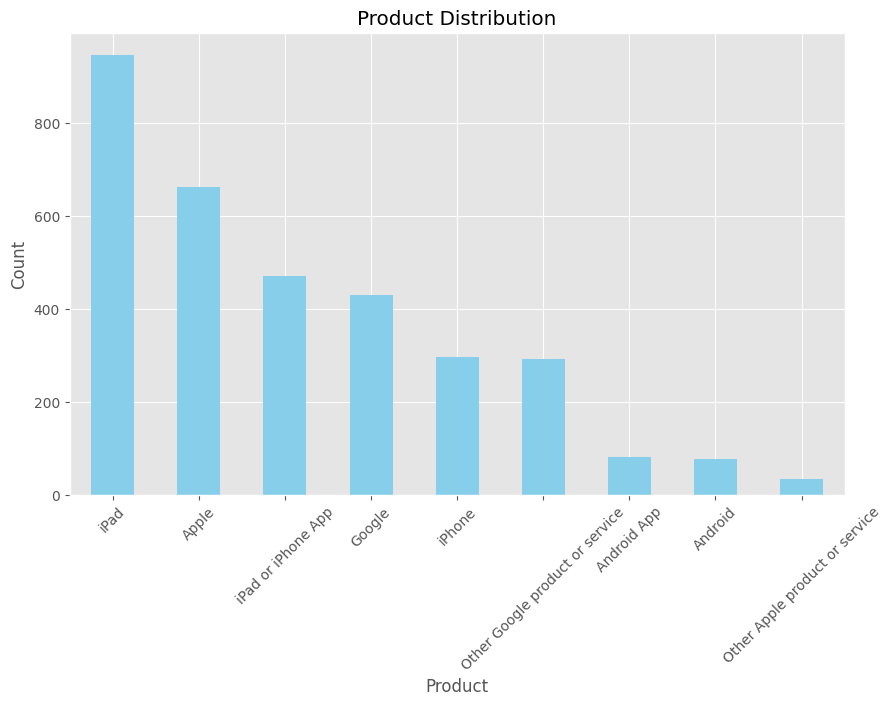

In [86]:
# Count the occurrences of each product
product_counts = data['product'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
product_counts.plot(kind='bar', color='skyblue')
plt.title('Product Distribution')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


## Missing Values

In [87]:
# check missing missing values
# Data types of columns
data_types = data.dtypes
print("Data types of columns:")
print(data_types)

# Missing values
missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)

Data types of columns:
tweet        object
product      object
sentiment    object
dtype: object

Missing values:
tweet           1
product      5802
sentiment       0
dtype: int64


## Extract Related words to Apple and Google Products

In [88]:
# Function to extract related words to Apple and Google Products
def extract_product(tweet):
    # Dictionary maps keywords to products
    tweet_lower = str(tweet).lower()
    product_keywords = {
        'Apple': ['apple', 'iphone', 'ipad', 'macbook', 'apple watch',
                  'airpods', 'ios', 'macos', 'app store', 'icloud', 'itunes'],
        'Google': ['google', 'pixel', 'pixelbook', 'chromebook', 'google home',
                   'nest', 'android', 'google play store',
                   'google maps', 'gmail', 'goog']
    }

    # Check if tweet is a string
    if isinstance(tweet, str):
        # Iterate through the dictionary to find a match
        for product, keywords in product_keywords.items():
            if any(keyword in tweet_lower for keyword in keywords):
                return product
    return None

# Replace NaN values  in 'product' column with appropriate match
data['product'] = data.apply(lambda row: extract_product(row['tweet']) if pd.isna(row['product']) else row['product'], axis=1)


## Check Missing Values in the entire Dataset

In [89]:
# Check for missing values
missing_values = data.isnull().sum()

print("Missing values per column:")
print(missing_values)


Missing values per column:
tweet          1
product      703
sentiment      0
dtype: int64


There is 1 missing value in the 'tweet' column.

There are 703 missing values in the 'product' column.

There are 0 missing values in the 'sentiment' column.

## Drop Missing Values in Tweet and Product Column

In [90]:
#Drop missing values in tweet and product column
data.dropna(subset=['tweet','product'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8390 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8390 non-null   object
 1   product    8390 non-null   object
 2   sentiment  8390 non-null   object
dtypes: object(3)
memory usage: 262.2+ KB


## Drop "I can't tell" in the Sentiment Column

In [91]:
# drop values in the  sentiment that have "I can't tell' words
data = data[data['sentiment'] != "I can't tell"]

# Replace 'No emotion toward brand or product' with 'Neutral'
data['sentiment'] = data['sentiment'].replace('No emotion toward brand or product', 'Neutral')

# Print unique sentiment values after changes
print("Unique sentiment values after changes:", data['sentiment'].unique())



Unique sentiment values after changes: ['Negative emotion' 'Positive emotion' 'Neutral']


## Data Pre-processing

## Check Top Most Common Words in the Tweets

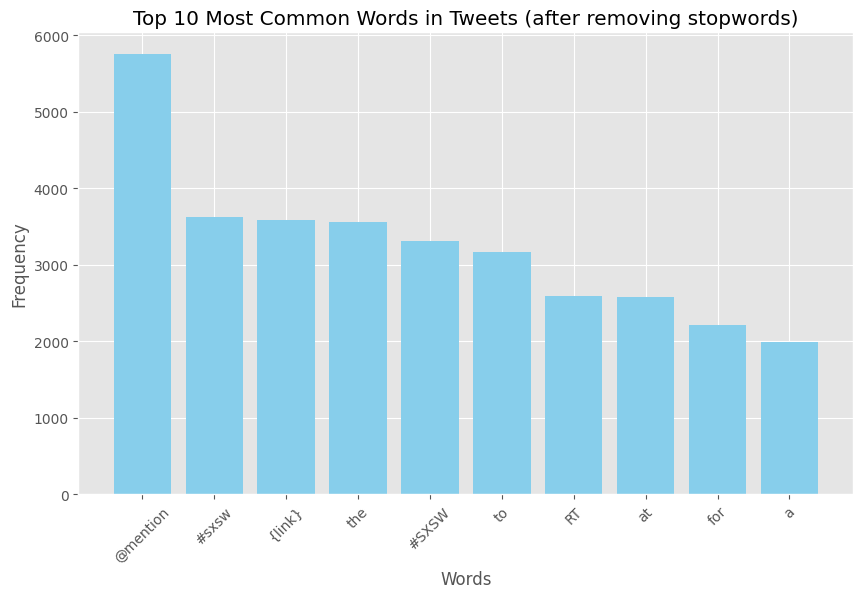

In [92]:
# Tokenization
tokenized_tweets = [word for tweet in data['tweet'] for word in tweet.split()]

# Counting
word_counts = Counter(tokenized_tweets)

# Remove stopwords, punctuation, urls
# Sorting
most_common_words = word_counts.most_common()

# Visualize
top_n = 10  # Choose the number of top words to display
top_words, top_counts = zip(*most_common_words[:top_n])

plt.figure(figsize=(10, 6))
plt.bar(top_words, top_counts, color='skyblue')  # Set color to skyblue
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words in Tweets (after removing stopwords)')
plt.xticks(rotation=45)
plt.show()


### Tokenization

## Handle (words that start with @), HTML tags and URLs in tweets

In [93]:
# function to handle @), HTML tags and URLs in tweets
def preprocess_text(text):
    # convert text lower case
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Remove Twitter usernames (mentions)
    text = re.sub(r'@\w+\s*', '', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)

    return text

# Tokenize and remove stopwords
nltk.download('punkt')
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))
stopwords_list.update(string.punctuation)
common_words = ['sxsw','mention','link','sxtxstate']
stopwords_list.update(common_words)

def preprocess_and_tokenize(text):
    text = preprocess_text(text)
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords_list]
    return ' '.join(filtered_tokens)

# Apply preprocessing and tokenization to the 'tweet' column
data['tweet'] = data['tweet'].apply(preprocess_and_tokenize)

# Convert tokenized text into numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_representation = tfidf_vectorizer.fit_transform(data['tweet'])

# Show the first 5 rows of the preprocessed data
data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet,product,sentiment
0,g iphone hrs tweeting riseaustin dead need upg...,iPhone,Negative emotion
1,know awesome ipadiphone app youll likely appre...,iPad or iPhone App,Positive emotion
2,wait ipad also sale,iPad,Positive emotion
3,hope years festival isnt crashy years iphone app,iPad or iPhone App,Negative emotion
4,great stuff fri marissa mayer google tim oreil...,Google,Positive emotion


In [94]:
data.columns

Index(['tweet', 'product', 'sentiment'], dtype='object')

In [95]:
print(tfidf_representation)

  (0, 7933)	0.40315374358409556
  (0, 6097)	0.3800616657204469
  (0, 8955)	0.333517305678
  (0, 5368)	0.21781680412112528
  (0, 1999)	0.35349053302536515
  (0, 7086)	0.40315374358409556
  (0, 8815)	0.30553338917870465
  (0, 3873)	0.3718197463847083
  (0, 4214)	0.12350369359105624
  (1, 8763)	0.3903687325353203
  (1, 3115)	0.1932420269683766
  (1, 3337)	0.2531224244219872
  (1, 8484)	0.2769880081574632
  (1, 215)	0.2500602092348758
  (1, 2093)	0.22746447148343096
  (1, 391)	0.3600284145632051
  (1, 4670)	0.326184481096034
  (1, 9531)	0.28675540892050305
  (1, 346)	0.15034973784821384
  (1, 4193)	0.3376686441016936
  (1, 592)	0.2311449430828301
  (1, 4477)	0.21658180462489027
  (2, 7202)	0.6187707925916311
  (2, 4183)	0.20103306137892596
  (2, 9139)	0.5369862262982831
  :	:
  (8237, 9434)	0.2662888407060977
  (8237, 6962)	0.25769899410908526
  (8237, 6926)	0.2662888407060977
  (8237, 5401)	0.1965573065079014
  (8237, 6187)	0.23033963605808064
  (8237, 9519)	0.178899862036244
  (8237, 342

## Visualise the Word Cloud of words in the Tweet Column

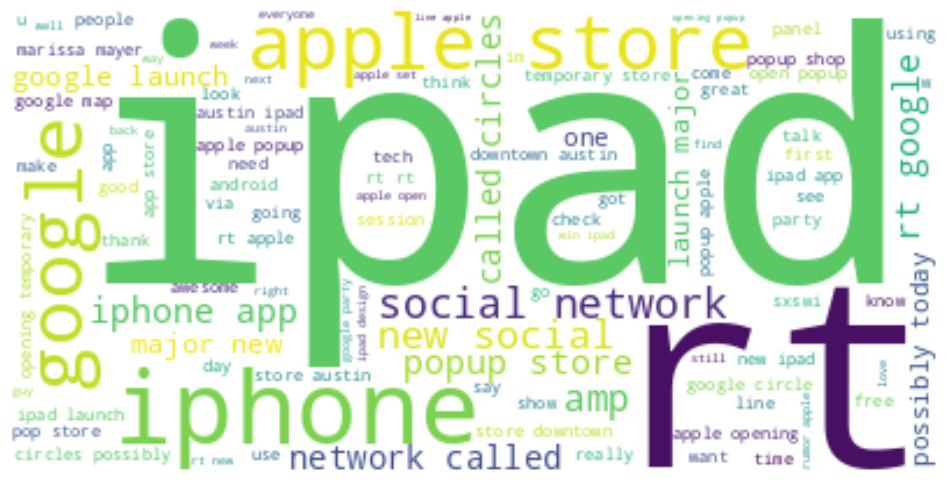

In [96]:
# generate a wordcloud
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white")
wordcloud.generate(' '.join(data['tweet']))

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [97]:
data.head()

,tweet,product,sentiment
0,g iphone hrs tweeting riseaustin dead need upg...,iPhone,Negative emotion
1,know awesome ipadiphone app youll likely appre...,iPad or iPhone App,Positive emotion
2,wait ipad also sale,iPad,Positive emotion
3,hope years festival isnt crashy years iphone app,iPad or iPhone App,Negative emotion
4,great stuff fri marissa mayer google tim oreil...,Google,Positive emotion


## Visualise Distribution of the Sentiments

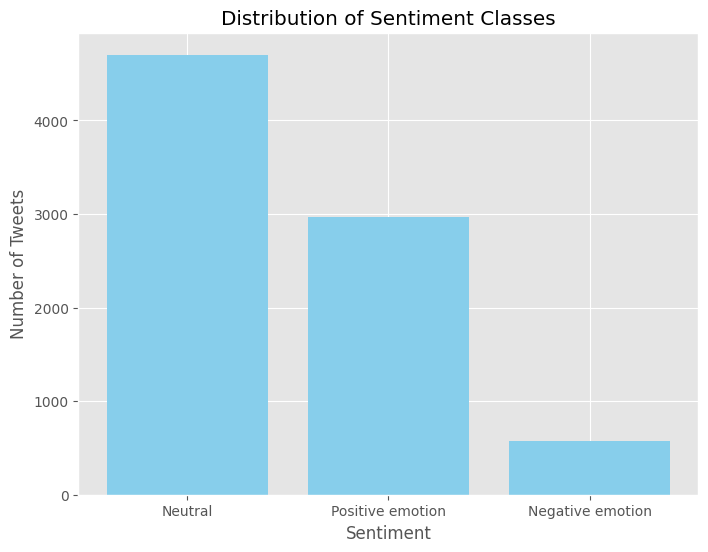

In [98]:
# Count the number of tweets in each sentiment class
sentiment_counts = data['sentiment'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')

# Set the chart title and labels
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# show the plot
plt.show()


## Check Class Imbalance in the Dataset

In [99]:
# Calculate the proportion of each sentiment class
sentiment_proportions = data['sentiment'].value_counts(normalize=True)

# Print the sentiment proportions
print(sentiment_proportions)

# Check for class imbalance by comparing the proportions
if sentiment_proportions.max() / sentiment_proportions.min() > 2:
  print('There is class imbalance in the dataset.')
else:
  print('The dataset is balanced.')


sentiment
Neutral             0.570752
Positive emotion    0.360194
Negative emotion    0.069053
Name: proportion, dtype: float64
There is class imbalance in the dataset.


In [100]:
data.head()

,tweet,product,sentiment
0,g iphone hrs tweeting riseaustin dead need upg...,iPhone,Negative emotion
1,know awesome ipadiphone app youll likely appre...,iPad or iPhone App,Positive emotion
2,wait ipad also sale,iPad,Positive emotion
3,hope years festival isnt crashy years iphone app,iPad or iPhone App,Negative emotion
4,great stuff fri marissa mayer google tim oreil...,Google,Positive emotion


There is class imbalance in the dataset, therefore the dataset won't perform best

## Label the Sentiments - Positive, Negative, Neutral

In [101]:
integer_tweet = {'Positive emotion':1,'Negative emotion':0,'Neutral':2}
data['sentiment'] = data['sentiment'].replace(integer_tweet)
data.head()

,tweet,product,sentiment
0,g iphone hrs tweeting riseaustin dead need upg...,iPhone,0
1,know awesome ipadiphone app youll likely appre...,iPad or iPhone App,1
2,wait ipad also sale,iPad,1
3,hope years festival isnt crashy years iphone app,iPad or iPhone App,0
4,great stuff fri marissa mayer google tim oreil...,Google,1


## Stemming

In [102]:
# Stemming function
def stem_text(text):
    stemmer = PorterStemmer()
    tokenized_text = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in tokenized_text]
    return " ".join(stemmed_text)

# Apply stemming to your text data
data['stemmed_tweet'] = data['tweet'].apply(stem_text)

# Create Bag-of-Words representation
count_vectorizer = TfidfVectorizer()
bow_representation = count_vectorizer.fit_transform(data['stemmed_tweet'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_representation, data['sentiment'], test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution
print(pd.Series(y_train_resampled).value_counts())

sentiment
2    3791
1    3791
0    3791
Name: count, dtype: int64


This balanced distribution of samples across the sentiment classes is beneficial for training machine learning models, especially in scenarios where there is a class imbalance issue, as it helps prevent bias towards the majority class.

In [103]:
# Filter the dataset to include only positive and negative sentiments
filtered_data = data[data['sentiment'].isin([0, 1])]

print(filtered_data)

                                                  tweet  \
0     g iphone hrs tweeting riseaustin dead need upg...   
1     know awesome ipadiphone app youll likely appre...   
2                                   wait ipad also sale   
3      hope years festival isnt crashy years iphone app   
4     great stuff fri marissa mayer google tim oreil...   
...                                                 ...   
9077  pr guy convinced switch back iphone great cove...   
9079     quotpapyrussort like ipadquot nice lol lavelle   
9080  diller says google tv quotmight run playstatio...   
9085  ive always used camera iphone bc image stabili...   
9088                                    ipad everywhere   

                              product  sentiment  \
0                              iPhone          0   
1                  iPad or iPhone App          1   
2                                iPad          1   
3                  iPad or iPhone App          0   
4                              


## Baseline Model

### Binary Logistic Regression




In [104]:
# Create Bag-of-Words representation
count_vectorizer = TfidfVectorizer()
bow_representation = count_vectorizer.fit_transform(filtered_data['tweet'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_representation, filtered_data['sentiment'], test_size=0.2, random_state=42)

# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Predictions on training set
train_predictions = logistic_model.predict(X_train)

# Evaluate the model on training set
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)
train_roc_auc = roc_auc_score(y_train, train_predictions)

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print(f"ROC AUC Score: {train_roc_auc}")

# Predictions on testing set
test_predictions = logistic_model.predict(X_test)

# Evaluate the model on testing set
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
test_roc_auc = roc_auc_score(y_test, test_predictions)

print("\nTesting Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print(f"ROC AUC Score: {test_roc_auc}")

#

Training Set Metrics:
Accuracy: 0.8628490632732414
Precision: 0.8598772119898881
Recall: 1.0
F1 Score: 0.9246601941747573
ROC AUC Score: 0.5669642857142857

Testing Set Metrics:
Accuracy: 0.8347457627118644
Precision: 0.8347578347578347
Recall: 0.9982964224872232
F1 Score: 0.9092319627618308
ROC AUC Score: 0.519809368268405


## Mutlticlass Logistic Regression

In [105]:
# Create TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
tfidf_representation = tfidf_vectorizer.fit_transform(data['tweet'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_representation, data['sentiment'], test_size=0.2, random_state=42)

# Logistic Regression model
logistic_model = LogisticRegression(multi_class='multinomial')

# Train the model on the training data
logistic_model.fit(X_train, y_train)

# Predictions on training set
train_predictions = logistic_model.predict(X_train)

# Evaluate the model on training set
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, average='weighted')
train_recall = recall_score(y_train, train_predictions, average='weighted')
train_f1 = f1_score(y_train, train_predictions, average='weighted')

print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")

# Predictions on testing set
test_predictions = logistic_model.predict(X_test)

# Evaluate the model on testing set
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions, average='weighted')
test_recall = recall_score(y_test, test_predictions, average='weighted')
test_f1 = f1_score(y_test, test_predictions, average='weighted')

print("\nTesting Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")


Training Set Metrics:
Accuracy: 0.8184162621359223
Precision: 0.8312725722769176
Recall: 0.8184162621359223
F1 Score: 0.8008306660024322

Testing Set Metrics:
Accuracy: 0.6504854368932039
Precision: 0.6624566394831398
Recall: 0.6504854368932039
F1 Score: 0.619558543645514


Binary SVM

In [106]:
# vectorizer
tfidf_vectorizer_bi = TfidfVectorizer()
Bi_tfidf_representation = tfidf_vectorizer_bi.fit_transform(filtered_data['tweet'])

X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(Bi_tfidf_representation, filtered_data['sentiment'], test_size=0.2, random_state=42)

# SVM model
svm_model_bi = SVC()

# Train the SVM model on the training data
svm_model_bi.fit(X_train_bi, y_train_bi)

# Predictions on training set
svm_train_predictions_bi = svm_model_bi.predict(X_train_bi)

# Evaluate the SVM model on training set
svm_train_accuracy_bi = accuracy_score(y_train_bi, svm_train_predictions_bi)
svm_train_precision_bi = precision_score(y_train_bi, svm_train_predictions_bi, average='weighted')
svm_train_recall_bi = recall_score(y_train_bi, svm_train_predictions_bi, average='weighted')
svm_train_f1_bi = f1_score(y_train_bi, svm_train_predictions_bi, average='weighted')
svm_train_roc_auc_bi = roc_auc_score(y_train_bi, svm_train_predictions_bi)

print("SVM Training Set Metrics:")
print(f"Accuracy: {svm_train_accuracy_bi}")
print(f"Precision: {svm_train_precision_bi}")
print(f"Recall: {svm_train_recall_bi}")
print(f"F1 Score: {svm_train_f1_bi}")
print(f"ROC AUC Score: {svm_train_roc_auc_bi}")

# Predictions on testing set
svm_test_predictions_bi = svm_model_bi.predict(X_test_bi)

# Evaluate the SVM model on testing set
svm_test_accuracy_bi = accuracy_score(y_test_bi, svm_test_predictions_bi)
svm_test_precision_bi = precision_score(y_test_bi, svm_test_predictions_bi, average='weighted')
svm_test_recall_bi = recall_score(y_test_bi, svm_test_predictions_bi, average='weighted')
svm_test_f1_bi = f1_score(y_test_bi, svm_test_predictions_bi, average='weighted')
svm_test_roc_auc_bi = roc_auc_score(y_test_bi, svm_test_predictions_bi)

print("\nSVM Testing Set Metrics:")
print(f"Accuracy: {svm_test_accuracy_bi}")
print(f"Precision: {svm_test_precision_bi}")
print(f"Recall: {svm_test_recall_bi}")
print(f"F1 Score: {svm_test_f1_bi}")
print(f"ROC AUC Score: {svm_test_roc_auc_bi}")

# Binary Naive Bayes model
nb_model_bi = BernoulliNB()

# Train the Binary Naive Bayes model on the training data
nb_model_bi.fit(X_train_bi, y_train_bi)

# Predictions on training set
nb_train_predictions_bi = nb_model_bi.predict(X_train_bi)

# Evaluate the Binary Naive Bayes model on training set
nb_train_accuracy_bi = accuracy_score(y_train_bi, nb_train_predictions_bi)
nb_train_precision_bi = precision_score(y_train_bi, nb_train_predictions_bi, average='weighted')
nb_train_recall_bi = recall_score(y_train_bi, nb_train_predictions_bi, average='weighted')
nb_train_f1_bi = f1_score(y_train_bi, nb_train_predictions_bi, average='weighted')
nb_train_roc_auc_bi = roc_auc_score(y_train_bi, nb_train_predictions_bi)

print("\nNaive Bayes Training Set Metrics:")
print(f"Accuracy: {nb_train_accuracy_bi}")
print(f"Precision: {nb_train_precision_bi}")
print(f"Recall: {nb_train_recall_bi}")
print(f"F1 Score: {nb_train_f1_bi}")
print(f"ROC AUC Score: {nb_train_roc_auc_bi}")

# Predictions on testing set
nb_test_predictions_bi = nb_model_bi.predict(X_test_bi)

# Evaluate the Binary Naive Bayes model on testing set
nb_test_accuracy_bi = accuracy_score(y_test_bi, nb_test_predictions_bi)
nb_test_precision_bi = precision_score(y_test_bi, nb_test_predictions_bi, average='weighted')
nb_test_recall_bi = recall_score(y_test_bi, nb_test_predictions_bi, average='weighted')
nb_test_f1_bi = f1_score(y_test_bi, nb_test_predictions_bi, average='weighted')
nb_test_roc_auc_bi = roc_auc_score(y_test_bi, nb_test_predictions_bi)

print("\nNaive Bayes Testing Set Metrics:")
print(f"Accuracy: {nb_test_accuracy_bi}")
print(f"Precision: {nb_test_precision_bi}")
print(f"Recall: {nb_test_recall_bi}")
print(f"F1 Score: {nb_test_f1_bi}")
print(f"ROC AUC Score: {nb_test_roc_auc_bi}")

#Random Forest model
rf_model_bi = RandomForestClassifier()

# Train the Random Forest model on the training data
rf_model_bi.fit(X_train_bi, y_train_bi)

# Predictions on training set
rf_train_predictions_bi = rf_model_bi


SVM Training Set Metrics:
Accuracy: 0.9713679745493107
Precision: 0.9722004289678811
Recall: 0.9713679745493107
F1 Score: 0.9702173066437356
ROC AUC Score: 0.9105042899142016

SVM Testing Set Metrics:
Accuracy: 0.8587570621468926
Precision: 0.8629162276590037
Recall: 0.8587570621468926
F1 Score: 0.8191382314250304
ROC AUC Score: 0.5966181874498431

Naive Bayes Training Set Metrics:
Accuracy: 0.8989042064333687
Precision: 0.9083339561233215
Recall: 0.8989042064333687
F1 Score: 0.8785144294559412
ROC AUC Score: 0.6826157226855463

Naive Bayes Testing Set Metrics:
Accuracy: 0.844632768361582
Precision: 0.8224035110247155
Recall: 0.844632768361582
F1 Score: 0.8041671606876019
ROC AUC Score: 0.578258971940248


MultiClass SVM model

In [107]:
#  SVM model
svm_model = SVC()

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

# Predictions on training set
svm_train_predictions = svm_model.predict(X_train)

# Evaluate the SVM model on training set
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)
svm_train_precision = precision_score(y_train, svm_train_predictions, average='weighted')
svm_train_recall = recall_score(y_train, svm_train_predictions, average='weighted')
svm_train_f1 = f1_score(y_train, svm_train_predictions, average='weighted')

print("SVM Training Set Metrics:")
print(f"Accuracy: {svm_train_accuracy}")
print(f"Precision: {svm_train_precision}")
print(f"Recall: {svm_train_recall}")
print(f"F1 Score: {svm_train_f1}")

# Predictions on testing set
svm_test_predictions = svm_model.predict(X_test)

# Evaluate the SVM model on testing set
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)
svm_test_precision = precision_score(y_test, svm_test_predictions, average='weighted')
svm_test_recall = recall_score(y_test, svm_test_predictions, average='weighted')
svm_test_f1 = f1_score(y_test, svm_test_predictions, average='weighted')

print("\nSVM Testing Set Metrics:")
print(f"Accuracy: {svm_test_accuracy}")
print(f"Precision: {svm_test_precision}")
print(f"Recall: {svm_test_recall}")
print(f"F1 Score: {svm_test_f1}")

# Binary Naive Bayes model
nb_model = BernoulliNB()

# Train the Binary Naive Bayes model on the training data
nb_model.fit(X_train, y_train)

# Predictions on training set
nb_train_predictions = nb_model.predict(X_train)

# Evaluate the Binary Naive Bayes model on training set
nb_train_accuracy = accuracy_score(y_train, nb_train_predictions)
nb_train_precision = precision_score(y_train, nb_train_predictions, average='weighted')
nb_train_recall = recall_score(y_train, nb_train_predictions, average='weighted')
nb_train_f1 = f1_score(y_train, nb_train_predictions, average='weighted')

print("\nNaive Bayes Training Set Metrics:")
print(f"Accuracy: {nb_train_accuracy}")
print(f"Precision: {nb_train_precision}")
print(f"Recall: {nb_train_recall}")
print(f"F1 Score: {nb_train_f1}")

# Predictions on testing set
nb_test_predictions = nb_model.predict(X_test)

# Evaluate the Binary Naive Bayes model on testing set
nb_test_accuracy = accuracy_score(y_test, nb_test_predictions)
nb_test_precision = precision_score(y_test, nb_test_predictions, average='weighted')
nb_test_recall = recall_score(y_test, nb_test_predictions, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_predictions, average='weighted')

print("\nNaive Bayes Testing Set Metrics:")
print(f"Accuracy: {nb_test_accuracy}")
print(f"Precision: {nb_test_precision}")
print(f"Recall: {nb_test_recall}")
print(f"F1 Score: {nb_test_f1}")

# Random Forest model
rf_model = RandomForestClassifier()

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Predictions on training set
rf_train_predictions = rf_model.predict(X_train)

# Evaluate the Random Forest model on training set
rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_train_precision = precision_score(y_train, rf_train_predictions, average='weighted')
rf_train_recall = recall_score(y_train, rf_train_predictions, average='weighted')
rf_train_f1 = f1_score(y_train, rf_train_predictions, average='weighted')

print("\nRandom Forest Training Set Metrics:")
print(f"Accuracy: {rf_train_accuracy}")
print(f"Precision: {rf_train_precision}")
print(f"Recall: {rf_train_recall}")
print(f"F1 Score: {rf_train_f1}")

# Predictions on testing set
rf_test_predictions = rf_model.predict(X_test)

# Evaluate the Random Forest model on testing set
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_test_precision = precision_score(y_test, rf_test_predictions, average='weighted')
rf_test_recall = recall_score(y_test, rf_test_predictions, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_predictions, average='weighted')

print("\nRandom Forest Testing Set Metrics:")
print(f"Accuracy: {rf_test_accuracy}")
print(f"Precision: {rf_test_precision}")
print(f"Recall: {rf_test_recall}")
print(f"F1 Score: {rf_test_f1}")


SVM Training Set Metrics:
Accuracy: 0.9060983009708737
Precision: 0.913342310493026
Recall: 0.9060983009708737
F1 Score: 0.903004314008369

SVM Testing Set Metrics:
Accuracy: 0.6608009708737864
Precision: 0.6755394709555581
Recall: 0.6608009708737864
F1 Score: 0.6325415840722951

Naive Bayes Training Set Metrics:
Accuracy: 0.7977851941747572
Precision: 0.8145094388246751
Recall: 0.7977851941747572
F1 Score: 0.7709500414968433

Naive Bayes Testing Set Metrics:
Accuracy: 0.6316747572815534
Precision: 0.6481896000241345
Recall: 0.6316747572815534
F1 Score: 0.6016701235293687

Random Forest Training Set Metrics:
Accuracy: 0.991504854368932
Precision: 0.991534060353922
Recall: 0.991504854368932
F1 Score: 0.9914969260890149

Random Forest Testing Set Metrics:
Accuracy: 0.6510922330097088
Precision: 0.6512471881452809
Recall: 0.6510922330097088
F1 Score: 0.6304572519807788


# Visualization ROC CURVES of the best performing  models

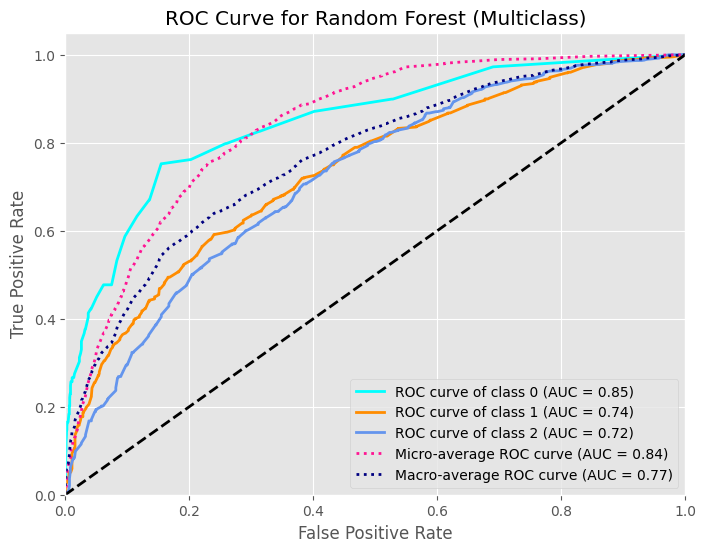

In [108]:
# visualise ROC Curves of the Best perfoming models
# Binarize the labels for the
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get the class labels
classes = lb.classes_
y_test_prob = rf_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average and compute AUC
mean_tpr /= len(classes)

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot all ROC curves
plt.figure(figsize=(8, 6))

# Plot ROC curve for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, color='deeppink', linestyle=':',
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:0.2f})', lw=2)

# Plot macro-average ROC curve
plt.plot(fpr_macro, tpr_macro, color='navy', linestyle=':',
         label=f'Macro-average ROC curve (AUC = {roc_auc_macro:0.2f})', lw=2)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (Multiclass)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Visualise ROC Curve of all Random Forest Classes

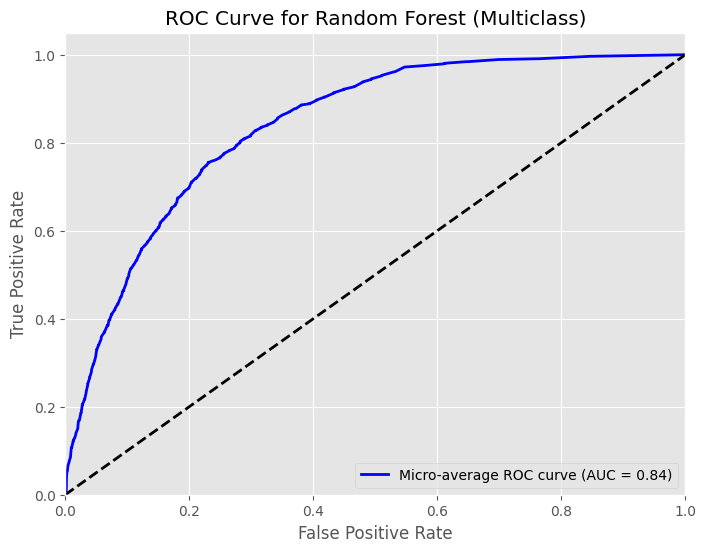

In [109]:
# visualise ROC Curve for combined for all classes of the Random forest
# Binarize the labels
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Get the probabilities for each class
y_test_prob = rf_model.predict_proba(X_test)

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='blue', lw=2,
         label=f'Micro-average ROC curve (AUC = {roc_auc_micro:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest (Multiclass)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Compute ROC curve for Naive Bayes Classes


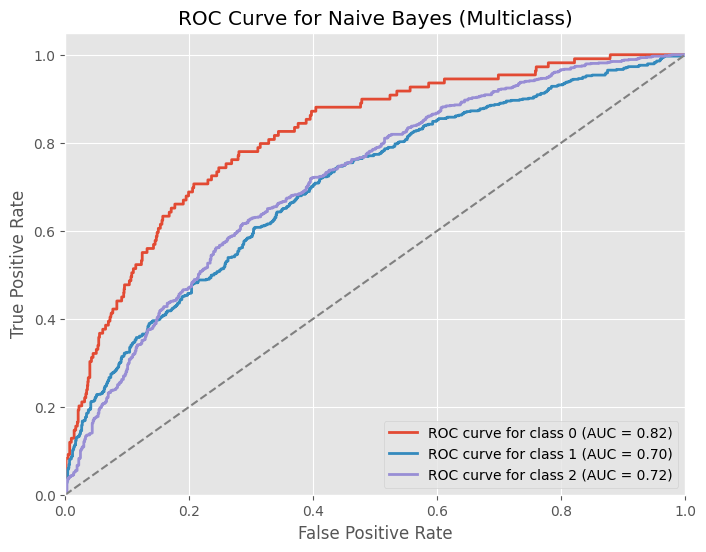

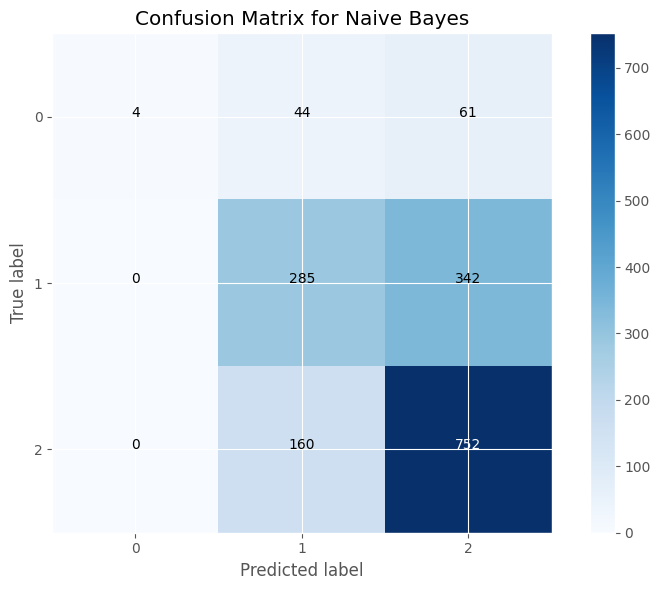

In [110]:
# Compute ROC curve for Naive Bayes Classes
nb_probs = nb_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Binarize the target labels
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming you have 3 classes (0, 1, 2)
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], nb_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], nb_probs[:, i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(3):  # Assuming you have 3 classes (0, 1, 2)
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Naive Bayes (Multiclass)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Compute confusion matrix for Naive Bayes
nb_predictions = nb_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, nb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Naive Bayes')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
tick_marks = np.arange(len(np.unique(y_test)))  # Assuming you have variable number of classes
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()


### Multiclass Classification

### Support Vector Machine (SVM): Baseline model


SVM:
Validation Accuracy: 0.8775894538606404
Validation Precision: 0.8931298552259888
Validation Recall: 0.8775894538606404
Validation F1-score: 0.8431131952822568
Validation AUC: 0.8862522637690422


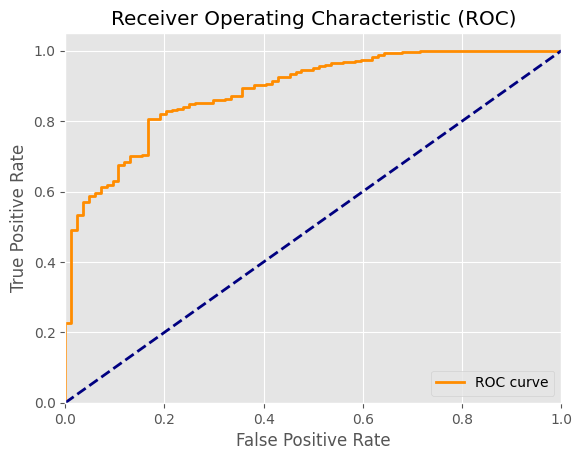


Naive Bayes:
Validation Accuracy: 0.8512241054613936
Validation Precision: 0.8735687740327812
Validation Recall: 0.8512241054613936
Validation F1-score: 0.7912340747963699
Validation AUC: 0.8089645254074784


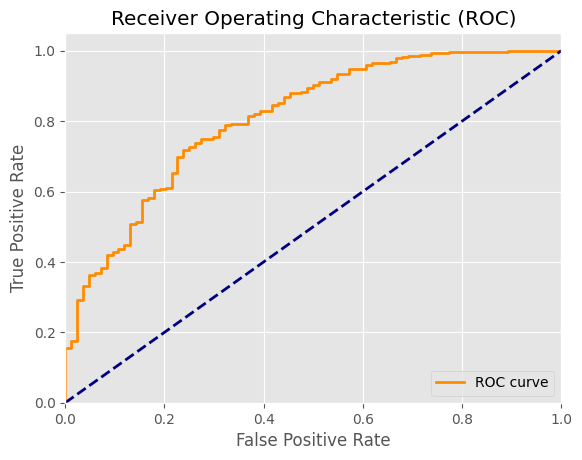


Random Forest:
Validation Accuracy: 0.8870056497175142
Validation Precision: 0.8884062383707162
Validation Recall: 0.8870056497175142
Validation F1-score: 0.8634620234344712
Validation AUC: 0.836875466070097


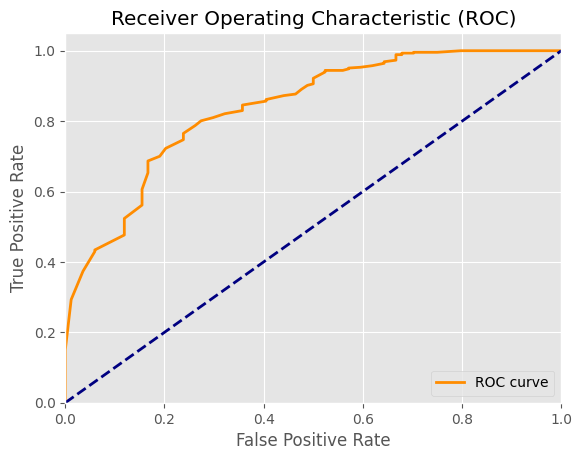

In [111]:
# SVM multiclass model
# Split the filtered dataset into features (X) and target variable (y)
X_filtered = filtered_data['tweet']
y_filtered = filtered_data['sentiment']

# Split the filtered dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Convert the target variable to binary format
y_val_binary = y_val_filtered

# Initialize CountVectorizer
count_vectorizer_filtered = TfidfVectorizer()

# Fit and transform the training data
X_train_bow_filtered = count_vectorizer_filtered.fit_transform(X_train_filtered)
X_val_bow_filtered = count_vectorizer_filtered.transform(X_val_filtered)
X_test_bow_filtered = count_vectorizer_filtered.transform(X_test_filtered)

# Initialize classifiers
classifiers = {
    "SVM": SVC(probability=True),  # Set probability=True to enable predict_proba
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name}:")
    clf.fit(X_train_bow_filtered, y_train_filtered)
    y_val_pred = clf.predict(X_val_bow_filtered)

    # Calculate evaluation metrics on the validation set
    accuracy_val = accuracy_score(y_val_filtered, y_val_pred)
    precision_val = precision_score(y_val_filtered, y_val_pred, average='weighted')
    recall_val = recall_score(y_val_filtered, y_val_pred, average='weighted')
    f1_val = f1_score(y_val_filtered, y_val_pred, average='weighted')
    auc_val = roc_auc_score(y_val_binary, clf.predict_proba(X_val_bow_filtered)[:, 1])

    # Print evaluation metrics
    print("Validation Accuracy:", accuracy_val)
    print("Validation Precision:", precision_val)
    print("Validation Recall:", recall_val)
    print("Validation F1-score:", f1_val)
    print("Validation AUC:", auc_val)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val_binary, clf.predict_proba(X_val_bow_filtered)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



SVM:
Validation Accuracy: 0.669093851132686
Validation Precision: 0.6720946902865307
Validation Recall: 0.669093851132686
Validation F1-score: 0.6404815644839519


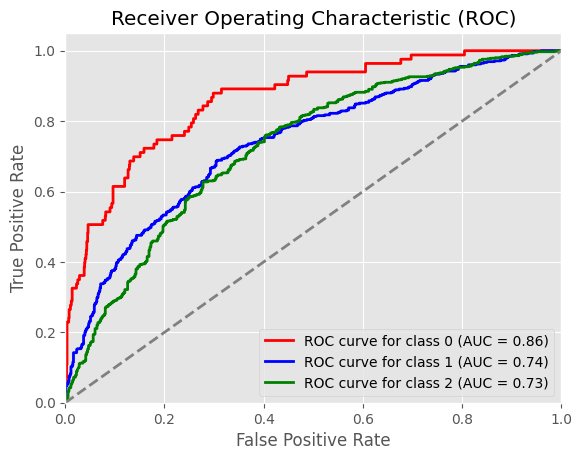


Naive Bayes:
Validation Accuracy: 0.6448220064724919
Validation Precision: 0.678036404126884
Validation Recall: 0.6448220064724919
Validation F1-score: 0.5878332327079565


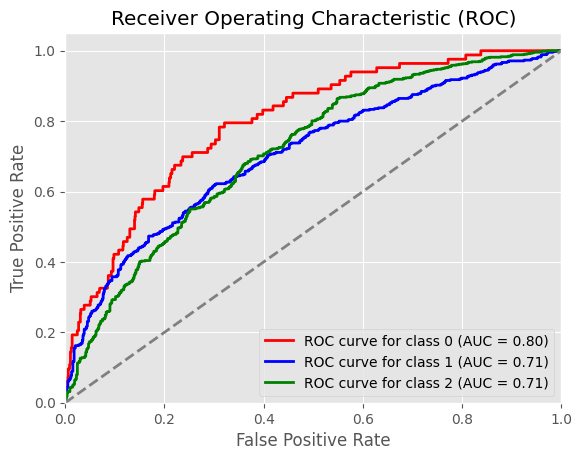


Random Forest:
Validation Accuracy: 0.6642394822006472
Validation Precision: 0.6637313438747693
Validation Recall: 0.6642394822006472
Validation F1-score: 0.6449342581069022


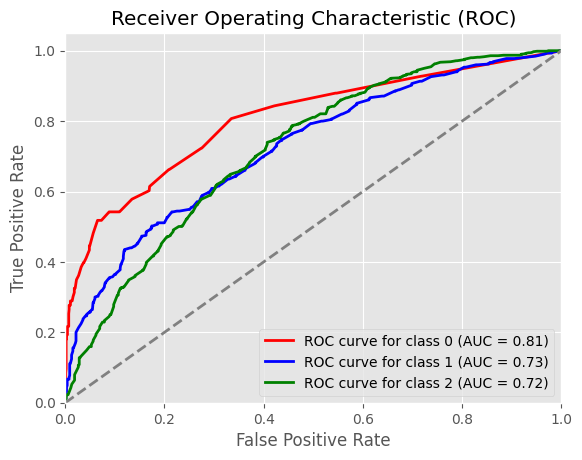

In [112]:

# Split the filtered dataset into features (X) and target variable (y)
X_filtered = data['tweet']
y_filtered = data['sentiment']

# Split the filtered dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Initialize TfidfVectorizer
tfidf_vectorizer_filtered = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf_filtered = tfidf_vectorizer_filtered.fit_transform(X_train_filtered)
X_val_tfidf_filtered = tfidf_vectorizer_filtered.transform(X_val_filtered)
X_test_tfidf_filtered = tfidf_vectorizer_filtered.transform(X_test_filtered)

# Initialize classifiers
classifiers = {
    "SVM": SVC(probability=True),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name}:")
    clf.fit(X_train_tfidf_filtered, y_train_filtered)
    y_val_pred = clf.predict(X_val_tfidf_filtered)

    # Calculate evaluation metrics on the validation set
    accuracy_val = accuracy_score(y_val_filtered, y_val_pred)
    precision_val = precision_score(y_val_filtered, y_val_pred, average='weighted')
    recall_val = recall_score(y_val_filtered, y_val_pred, average='weighted')
    f1_val = f1_score(y_val_filtered, y_val_pred, average='weighted')

    # Print evaluation metrics
    print("Validation Accuracy:", accuracy_val)
    print("Validation Precision:", precision_val)
    print("Validation Recall:", recall_val)
    print("Validation F1-score:", f1_val)

    # Plot ROC curve
    if len(np.unique(y_val_filtered)) > 2:  # Only plot ROC curve for multiclass classification
        n_classes = len(np.unique(y_val_filtered))
        y_val_binary = np.zeros((len(y_val_filtered), n_classes))
        for i, class_label in enumerate(np.unique(y_val_filtered)):
            y_val_binary[:, i] = (y_val_filtered == class_label)

        y_val_probs = clf.predict_proba(X_val_tfidf_filtered)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_val_binary[:, i], y_val_probs[:, i])
            roc_auc[i] = roc_auc_score(y_val_binary[:, i], y_val_probs[:, i])

        # Plot ROC curve for each class
        plt.figure()
        colors = ['red', 'blue', 'green']  # You can add more colors if you have more classes
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()


### Fine tune the best perfoming model: Random forest

In [ ]:
# random search

# hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_grid, n_iter=30, cv=5, scoring='f1_weighted', verbose=2, random_state=42)

# model to the training data
random_search.fit(X_train_tfidf_filtered, y_train_filtered)

# best parameters
best_params = random_search.best_params_

# model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_tfidf_filtered, y_train_filtered)

# Evaluate the best model
y_test_pred = best_model.predict(X_test_tfidf_filtered)
accuracy_test = accuracy_score(y_test_filtered, y_test_pred)
precision_test = precision_score(y_test_filtered, y_test_pred, average='weighted')
recall_test = recall_score(y_test_filtered, y_test_pred, average='weighted')
f1_test = f1_score(y_test_filtered, y_test_pred, average='weighted')

# Print evaluation metrics
print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1-score:", f1_test)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.3s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total t

## Save Model and Deployment:

In [ ]:
import joblib

vectorizer = TfidfVectorizer()
X_t = filtered_data['tweet']
x_depo = vectorizer.fit_transform(X_t)
y_depo = filtered_data['sentiment']

rf_model = RandomForestClassifier()
rf_model.fit(x_depo, y_depo)

#Save the Model
joblib.dump(rf_model, 'rf_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

#Load and Deploy model
loaded_model = joblib.load('rf_sentiment_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

#function to preprocess and predict sentiment
def predict_sentiment(tweet):
    # Stem the tweet
    stemmer = PorterStemmer()
    stemmed_tweet = [stemmer.stem(word) for word in tweet.split() if word not in stopwords_list]

    # Vectorize using loaded TF-IDF vectorizer
    tweet_tfidf = loaded_vectorizer.transform([' '.join(stemmed_tweet)])

    # Predict sentiment
    sentiment = loaded_model.predict(tweet_tfidf)[0]
    return sentiment

#predict sentiment of input tweet
input_tweet = "I hate google"
predicted_sentiment = predict_sentiment(input_tweet)
print("Predicted Sentiment:", predicted_sentiment)


### Examples of tweets

In [ ]:
google_complain_tweet = '''I hate how Google's user experience keeps changing every few months! It's so frustrating to constantly relearn how to use everything. #annoyed #ux'''
google_compliment_tweet = '''Love how intuitive Google's user experience is! Whether it's Gmail, Maps, or Drive, everything just works seamlessly. Kudos to the team! #impressed #ux'''
apple_complain_tweet = '''Ugh, I hate how Apple's customer experience is so inconsistent across their stores. Some staff are helpful, but others seem clueless. #frustrated #cx'''
apple_compliment_tweet = '''Love the customer experience at Apple! Visited their store today, and the staff went above and beyond to help me with my iPhone issues. Top-notch service! #impressed #cx'''
tweet_deploy_list = [google_complain_tweet,google_compliment_tweet,apple_complain_tweet,apple_compliment_tweet]
for tweet in tweet_deploy_list:
    predicted_sentiment = predict_sentiment(tweet)
    if predicted_sentiment == 0 :
        print(f' Negative Tweet: {tweet} \nPredicted Sentiment: Negative Sentiment ({predicted_sentiment})\n\n\n-------------------------------------------------------------------------------')
    else:
        print(f'Positive Tweet: {tweet} \nPredicted Sentiment: Positive Sentiment ({predicted_sentiment})\n\n\n-------------------------------------------------------------------------------')

**CONCLUSION**

While the sentiment analysis models achieved relatively high accuracy and recall scores, there is still room for improvement in terms of discriminative ability and overall performance. Further analysis and experimentation may help uncover insights to enhance the models' effectiveness in sentiment classification tasks.

**Challenges Faced**

Limited dataset size for certain brands/products. Imbalanced class distribution in the sentiment labels. Difficulty in accurately determining sentiment from short and informal text data. Difficulties in distinguishing advertising tweets, mentions, and retweets

**RECOMMENDATION REGARDING BUSINESS**

Customer Feedback Analysis: By analyzing sentiments expressed in customer feedback, businesses can gain deep insights into customer satisfaction levels, product/service performance, and areas for improvement. Brand Reputation Management: Monitoring sentiment towards their brand on social media platforms helps businesses understand public perception. Positive sentiment indicates brand loyalty and satisfaction, while negative sentiment may highlight issues requiring attention. Product Development: Identifying patterns in sentiment towards specific products or features enables businesses to tailor their product development strategies to meet customer needs and preferences more effectively.